Knn Classification

In [22]:
require(data.table)
require(ggplot2)
require(repr)
require(proxy)
#require(TSrepr)
#require(TSdist)
require(dtw)

In [6]:
options(repr.plot.width=15, repr.plot.height=8)
current_folder=getwd()
dataset_1='Earthquakes'
dataset_2='Fish'

train_data_path_1=sprintf('%s/%s/%s_TRAIN.txt',current_folder,dataset_1,dataset_1)
test_data_path_1=sprintf('%s/%s/%s_TEST.txt',current_folder,dataset_1,dataset_1)
dist_path=sprintf('%s/%s/distances/%s',current_folder,dataset_1,dataset_1)

traindata=as.matrix(fread(train_data_path_1))
testdata=as.matrix(fread(test_data_path_1))

trainclass=traindata[,1] 
testclass=testdata[,1] 

traindata=traindata[,2:ncol(traindata)]
testdata=testdata[,2:ncol(testdata)]

tlength=ncol(traindata)
n_series_train=nrow(traindata)
n_series_test=nrow(testdata)


head(traindata)

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V504,V505,V506,V507,V508,V509,V510,V511,V512,V513
-0.5180090,-0.5180090,2.6542109,-0.5180090,-0.5180090,-0.5180090,-0.5180090,1.4562427,2.5583734,-0.5180090,...,-0.5180090,-0.5180090,-0.5180090,-0.5180090,-0.5180090,-0.5180090,-0.5180090,-0.5180090,1.4658264,-0.5180090
1.9437326,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146,...,2.4577888,3.3655903,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146,-0.3531146
2.6385165,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,...,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023,-0.3161023
-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384,...,1.3669004,-0.5311384,2.1474024,-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384,-0.5311384
-0.5936650,2.0201053,1.1747275,-0.5936650,-0.5936650,1.6060427,1.2178590,1.5887901,-0.5936650,-0.5936650,...,1.2264853,-0.5936650,-0.5936650,-0.5936650,1.4939007,-0.5936650,-0.5936650,-0.5936650,1.8993371,-0.5936650
4.7267177,-0.2402468,-0.2402468,-0.2402468,-0.2402468,-0.2402468,-0.2402468,-0.2402468,-0.2402468,-0.2402468,...,-0.2402468,-0.2402468,-0.2402468,-0.2402468,3.8879257,-0.2402468,-0.2402468,-0.2402468,-0.2402468,-0.2402468


In [7]:
# get difference series

dt_ts_train=data.table(traindata)
dt_ts_train[,id:=1:.N]
long_train=melt(dt_ts_train,id.vars=c('id'))
long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_train=long_train[order(id,time)]
long_train[,diff_series:=value-shift(value,1),by=list(id)]
head(long_train)

dt_ts_test=data.table(testdata)
dt_ts_test[,id:=1:.N]
long_test=melt(dt_ts_test,id.vars=c('id'))
long_test[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_test=long_test[order(id,time)]
long_test[,diff_series:=value-shift(value,1),by=list(id)]
head(long_test)

diff_train=dcast(long_train[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_train)
diff_train=as.matrix(diff_train)

diff_test=dcast(long_test[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_test)
diff_test=as.matrix(diff_test)

id,variable,value,time,diff_series
1,V2,-0.518009,1,NA
1,V3,-0.518009,2,0.00000
1,V4,2.654211,3,3.17222
1,V5,-0.518009,4,-3.17222
1,V6,-0.518009,5,0.00000
1,V7,-0.518009,6,0.00000


id,variable,value,time,diff_series
1,V2,-0.2692722,1,NA
1,V3,-0.2692722,2,0.000000
1,V4,-0.2692722,3,0.000000
1,V5,-0.2692722,4,0.000000
1,V6,-0.2692722,5,0.000000
1,V7,3.1369352,6,3.406207


id,2,3,4,5,6,7,8,9,10,...,503,504,505,506,507,508,509,510,511,512
1,0.000000,3.1722198,-3.172220,0,0.000000,0.0000000,1.9742517,1.102131,-3.076382,...,0.000000,0.0000000,0.000000,0.000000,0.000000,0.000000,0,0,1.983835,-1.983835
2,-2.296847,0.0000000,0.000000,0,0.000000,0.0000000,0.0000000,0.000000,0.000000,...,2.810903,0.9078015,-3.718705,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
3,-2.954619,0.0000000,0.000000,0,0.000000,0.0000000,0.0000000,0.000000,0.000000,...,-4.438799,0.0000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
4,0.000000,0.0000000,0.000000,0,0.000000,0.0000000,0.0000000,0.000000,0.000000,...,1.898039,-1.8980388,2.678541,-2.678541,0.000000,0.000000,0,0,0.000000,0.000000
5,2.613770,-0.8453778,-1.768392,0,2.199708,-0.3881837,0.3709311,-2.182455,0.000000,...,1.820150,-1.8201503,0.000000,0.000000,2.087566,-2.087566,0,0,2.493002,-2.493002
6,-4.966965,0.0000000,0.000000,0,0.000000,0.0000000,0.0000000,0.000000,0.000000,...,0.000000,0.0000000,0.000000,0.000000,4.128173,-4.128173,0,0,0.000000,0.000000


id,2,3,4,5,6,7,8,9,10,...,503,504,505,506,507,508,509,510,511,512
1,0.000000,0.000000,0.000000,0.0000000,3.406207,-3.406207,0.000000,3.253463,-3.253463,...,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000
2,3.216911,-1.121747,-2.095164,0.0000000,0.000000,0.000000,0.000000,2.132247,-2.132247,...,0,2.085893,-2.085893,2.530884,-2.530884,0,0,0,2.104435,-2.104435
3,-2.635855,0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000,2.593342,-2.593342,...,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000
4,2.881304,-2.881304,2.974584,-0.5285845,-2.445999,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.000000,2.609851,...,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000
6,-2.313408,0.000000,0.000000,2.2391242,-2.239124,2.621155,-2.621155,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000


In [8]:
# calculate distances and store them to save time
large_number=10000
dist_euc=as.matrix(dist(traindata))
diag(dist_euc)=large_number
fwrite(dist_euc,sprintf('%s_euc_raw_dist.csv',dist_path),col.names=F)

dist_diff_euc=as.matrix(dist(diff_train))
diag(dist_diff_euc)=large_number
fwrite(dist_diff_euc,sprintf('%s_euc_diff_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist.csv',dist_path),col.names=F)


x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [9]:
dist_dtw=as.matrix(dtwDist(traindata,window.type='sakoechiba',window.size=10))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_10.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata,window.type='sakoechiba',window.size=20))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_20.csv',dist_path),col.names=F)   
                   
diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=10))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_10.csv',dist_path),col.names=F)

diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=20))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_20.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [15]:
# cv indices start here
require(TunePareto)

set.seed(13429)
nof_rep=10
n_fold=10
cv_indices=generateCVRuns(trainclass, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

str(cv_indices)

dist_folder=sprintf('%s/%s/distances/',current_folder,dataset_1)
dist_files=list.files(dist_folder, full.names=T)

Loading required package: TunePareto


List of 10
 $ Run  1 :List of 10
  ..$ Fold  1 : int [1:33] 251 212 56 30 29 188 222 214 269 199 ...
  ..$ Fold  2 : int [1:33] 126 239 50 202 176 72 303 73 111 291 ...
  ..$ Fold  3 : int [1:32] 28 129 204 122 1 290 253 283 32 292 ...
  ..$ Fold  4 : int [1:32] 186 103 153 163 120 25 127 71 128 46 ...
  ..$ Fold  5 : int [1:32] 151 147 90 119 44 130 105 95 279 12 ...
  ..$ Fold  6 : int [1:32] 245 23 124 149 265 233 80 78 272 246 ...
  ..$ Fold  7 : int [1:32] 263 47 5 172 187 231 259 313 181 99 ...
  ..$ Fold  8 : int [1:32] 58 318 40 297 304 284 320 155 104 206 ...
  ..$ Fold  9 : int [1:32] 226 137 34 57 287 300 81 184 180 85 ...
  ..$ Fold  10: int [1:32] 121 293 164 250 100 311 309 211 113 281 ...
 $ Run  2 :List of 10
  ..$ Fold  1 : int [1:33] 263 1 100 90 34 290 196 43 192 79 ...
  ..$ Fold  2 : int [1:33] 187 239 265 172 57 130 156 70 7 68 ...
  ..$ Fold  3 : int [1:32] 163 151 124 120 297 153 285 152 8 24 ...
  ..$ Fold  4 : int [1:32] 176 119 304 293 287 30 94 216 99 174 ..

ERROR: Error in sprintf("%s/%s/distances/", current_folder, dataset): 'dataset' nesnesi bulunamadı


In [16]:
dist_folder=sprintf('%s/%s/distances/',current_folder,dataset_1)
dist_files=list.files(dist_folder, full.names=T)

In [18]:
list.files(dist_folder)

[1] "Earthquakes_dtw_diff_dist_sakoe_10.csv"
[2] "Earthquakes_dtw_diff_dist_sakoe_20.csv"
[3] "Earthquakes_dtw_raw_dist.csv"          
[4] "Earthquakes_dtw_raw_dist_sakoe_10.csv" 
[5] "Earthquakes_dtw_raw_dist_sakoe_20.csv" 
[6] "Earthquakes_euc_diff_dist.csv"         
[7] "Earthquakes_euc_raw_dist.csv"

In [24]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    #print(str(test_distances_to_train))
    ordered_indices=apply(test_distances_to_train,1,order)
    if(k==1){
        nearest_class=as.numeric(trainclass[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {trainclass[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

In [25]:
k_levels=c(1,5,10)
approach_file=list.files(dist_folder)
result=vector('list',length(dist_files)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(dist_files)){ #
    print(dist_files[m])
    dist_mat=as.matrix(fread(dist_files[m],header=FALSE))
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass,test_indices,k=current_k)
                accuracy=sum(trainclass[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=approach_file[m],repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

[1] "/Users/batuhantuncel/Earthquakes/distances//Earthquakes_dtw_diff_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/Earthquakes/distances//Earthquakes_dtw_diff_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/Earthquakes/distances//Earthquakes_dtw_raw_dist.csv"
[1] "/Users/batuhantuncel/Earthquakes/distances//Earthquakes_dtw_raw_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/Earthquakes/distances//Earthquakes_dtw_raw_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/Earthquakes/distances//Earthquakes_euc_diff_dist.csv"
[1] "/Users/batuhantuncel/Earthquakes/distances//Earthquakes_euc_raw_dist.csv"


In [26]:
overall_results=rbindlist(result)
summarized_results=overall_results[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]

In [27]:
summarized_results[order(-avg_acc)]

approach,k,avg_acc,sdev_acc,result_count
Earthquakes_dtw_raw_dist_sakoe_20.csv,10,0.8149242,0.02227289,100
Earthquakes_dtw_diff_dist_sakoe_10.csv,10,0.8142992,0.02191340,100
Earthquakes_dtw_raw_dist.csv,10,0.8142803,0.02113261,100
Earthquakes_dtw_diff_dist_sakoe_20.csv,10,0.8124148,0.02202661,100
Earthquakes_dtw_raw_dist_sakoe_10.csv,10,0.8121212,0.02417083,100
Earthquakes_euc_raw_dist.csv,10,0.8109091,0.02490029,100
Earthquakes_euc_diff_dist.csv,10,0.8059280,0.03108968,100
Earthquakes_dtw_raw_dist_sakoe_10.csv,5,0.7993466,0.03420918,100
Earthquakes_dtw_raw_dist_sakoe_20.csv,5,0.7990814,0.03924520,100
Earthquakes_dtw_diff_dist_sakoe_10.csv,5,0.7957197,0.03571680,100


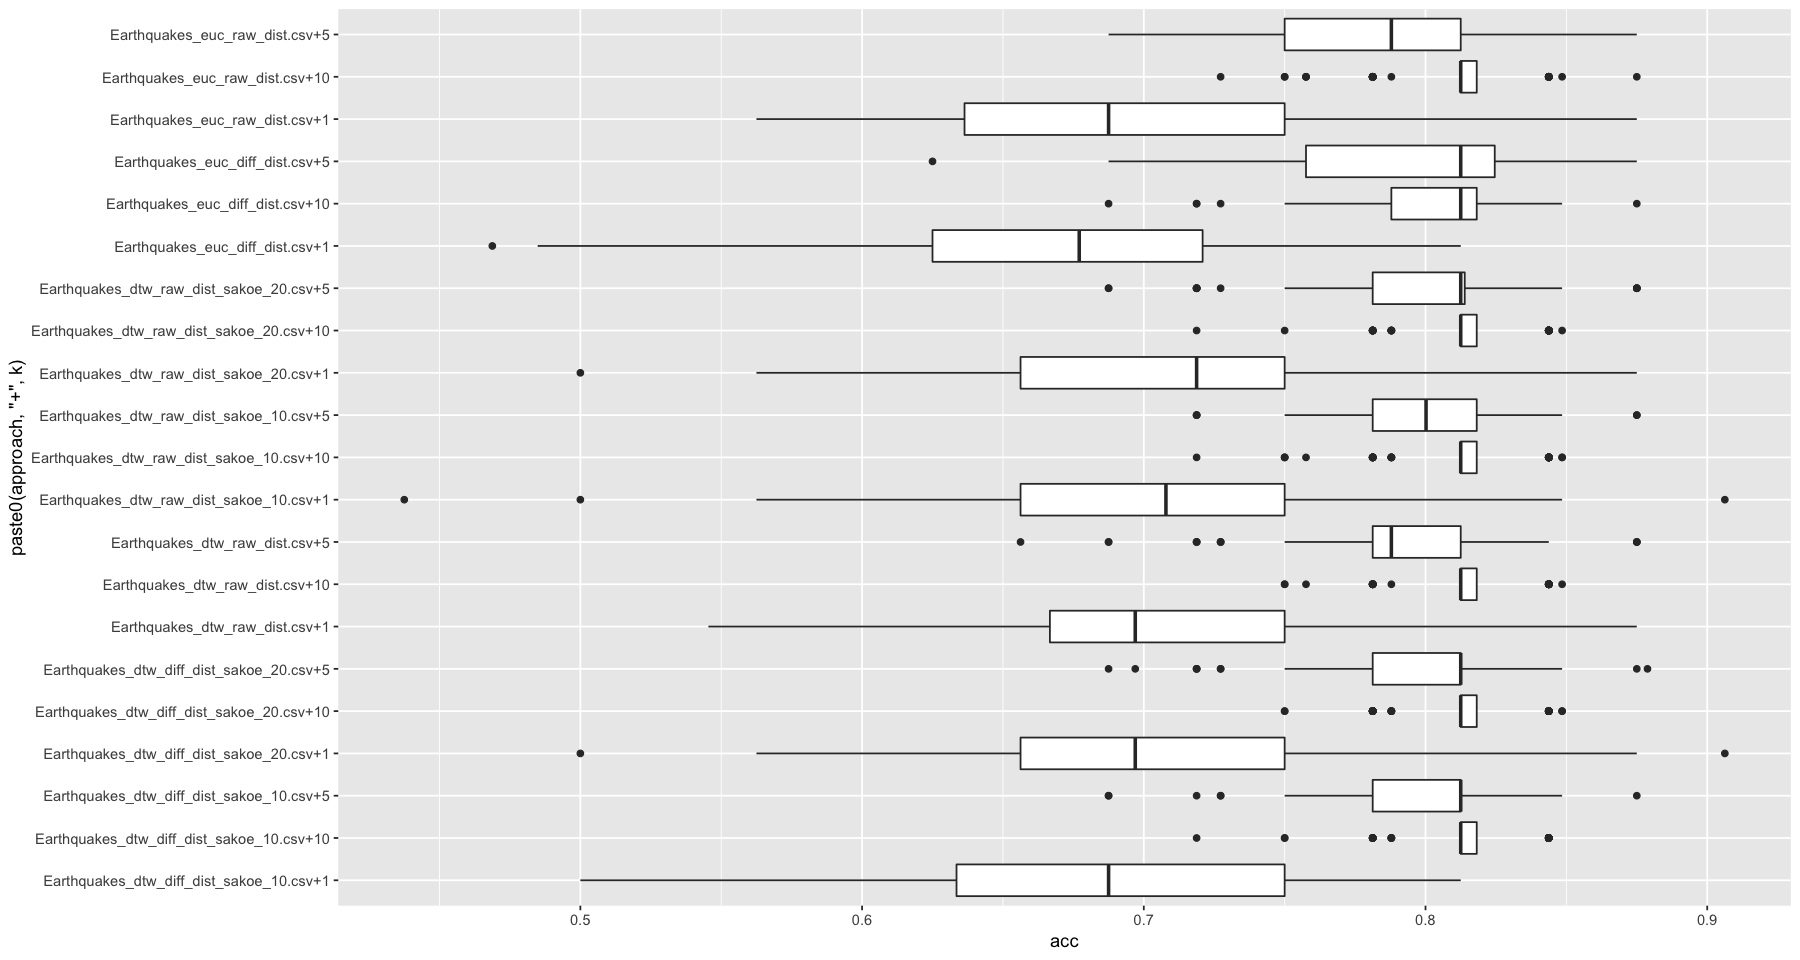

In [28]:
require(ggplot2)
ggplot(overall_results,aes(x=paste0(approach,'+',k), y=acc)) +
geom_boxplot()+
coord_flip()

In [30]:
train_data_path_2=sprintf('%s/%s/%s_TRAIN.txt',current_folder,dataset_2,dataset_2)
test_data_path_2=sprintf('%s/%s/%s_TEST.txt',current_folder,dataset_2,dataset_2)

#train_data_path_3=sprintf('%s/%s/%s_TRAIN.txt',current_folder,dataset_3,dataset_3)
#test_data_path_3=sprintf('%s/%s/%s_TEST.txt',current_folder,dataset_3,dataset_3)

#train_data_path_4=sprintf('%s/%s/%s_TRAIN.txt',current_folder,dataset_4,dataset_4)
#test_data_path_4=sprintf('%s/%s/%s_TEST.txt',current_folder,dataset_4,dataset_4)

#train_data_path_5=sprintf('%s/%s/%s_TRAIN.txt',current_folder,dataset_5,dataset_5)
#test_data_path_5=sprintf('%s/%s/%s_TEST.txt',current_folder,dataset_5,dataset_5)

traindata2=as.matrix(fread(train_data_path_2))
testdata2=as.matrix(fread(test_data_path_2))

trainclass2=traindata2[,1] 
testclass2=testdata2[,1] 

traindata2=traindata2[,2:ncol(traindata2)]
testdata2=testdata2[,2:ncol(testdata2)]

tlength2=ncol(traindata2)
n_series_train2=nrow(traindata2)
n_series_test2=nrow(testdata2)


head(traindata2)

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V455,V456,V457,V458,V459,V460,V461,V462,V463,V464
1.950905,1.926654,1.895665,1.858015,1.820566,1.790278,1.767617,1.731273,1.695241,1.658904,...,1.728209,1.766062,1.804372,1.842172,1.856651,1.862821,1.901062,1.939491,1.950465,1.950784
1.966652,1.940113,1.915149,1.945426,1.959289,1.945119,1.919668,1.881009,1.856474,1.818359,...,1.634491,1.674922,1.715240,1.755760,1.796475,1.823922,1.865034,1.893001,1.934836,1.966555
2.005598,1.994541,1.987894,1.970090,1.939982,1.903903,1.864944,1.826148,1.787538,1.749095,...,1.703027,1.732659,1.767108,1.805602,1.843613,1.882412,1.920517,1.954640,1.978782,2.000019
1.878433,1.871449,1.844617,1.811412,1.777580,1.742792,1.709533,1.677253,1.643310,1.609233,...,1.743214,1.788203,1.815747,1.842526,1.855507,1.816607,1.781343,1.806174,1.848362,1.878359
1.987342,1.968160,1.942338,1.909628,1.872595,1.843493,1.810693,1.774459,1.738029,1.703180,...,1.724225,1.761133,1.797601,1.834824,1.868354,1.902364,1.933093,1.957856,1.980278,1.984506
1.754350,1.716442,1.678512,1.640738,1.614897,1.577603,1.544358,1.507443,1.470516,1.433769,...,1.733626,1.741674,1.737074,1.712832,1.673220,1.652176,1.676269,1.701906,1.729801,1.750670


In [31]:
# get difference series

dt_ts_train=data.table(traindata2)
dt_ts_train[,id:=1:.N]
long_train=melt(dt_ts_train,id.vars=c('id'))
long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_train=long_train[order(id,time)]
long_train[,diff_series:=value-shift(value,1),by=list(id)]
head(long_train)

dt_ts_test=data.table(testdata2)
dt_ts_test[,id:=1:.N]
long_test=melt(dt_ts_test,id.vars=c('id'))
long_test[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_test=long_test[order(id,time)]
long_test[,diff_series:=value-shift(value,1),by=list(id)]
head(long_test)

diff_train=dcast(long_train[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_train)
diff_train=as.matrix(diff_train)

diff_test=dcast(long_test[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_test)
diff_test=as.matrix(diff_test)

id,variable,value,time,diff_series
1,V2,1.950905,1,NA
1,V3,1.926654,2,-0.0242509
1,V4,1.895665,3,-0.0309894
1,V5,1.858015,4,-0.0376492
1,V6,1.820566,5,-0.0374497
1,V7,1.790278,6,-0.0302873


id,variable,value,time,diff_series
1,V2,2.034879,1,NA
1,V3,2.024707,2,-0.0101713
1,V4,1.981236,3,-0.0434713
1,V5,1.949717,4,-0.0315196
1,V6,1.910241,5,-0.0394754
1,V7,1.866555,6,-0.0436861


id,2,3,4,5,6,7,8,9,10,...,454,455,456,457,458,459,460,461,462,463
1,-0.0242509,-0.0309894,-0.0376492,-0.0374497,-0.0302873,-0.0226615,-0.0363442,-0.0360319,-0.0363364,...,0.0376389,0.0378526,0.0383105,0.0378001,0.0144784,0.0061708,0.0382410,0.0384282,0.0109742,0.0003194
2,-0.0265394,-0.0249637,0.0302764,0.0138634,-0.0141700,-0.0254510,-0.0386587,-0.0245351,-0.0381154,...,0.0401439,0.0404311,0.0403185,0.0405196,0.0407145,0.0274471,0.0411119,0.0279669,0.0418357,0.0317185
3,-0.0110569,-0.0066474,-0.0178039,-0.0301078,-0.0360796,-0.0389590,-0.0387963,-0.0386099,-0.0384426,...,0.0278084,0.0296314,0.0344489,0.0384940,0.0380114,0.0387992,0.0381045,0.0341233,0.0241421,0.0212369
4,-0.0069841,-0.0268313,-0.0332055,-0.0338319,-0.0347879,-0.0332594,-0.0322798,-0.0339427,-0.0340768,...,0.0447052,0.0449891,0.0275444,0.0267786,0.0129817,-0.0389009,-0.0352632,0.0248303,0.0421882,0.0299967
5,-0.0191824,-0.0258211,-0.0327102,-0.0370335,-0.0291015,-0.0328005,-0.0362340,-0.0364296,-0.0348496,...,0.0372470,0.0369080,0.0364682,0.0372222,0.0335301,0.0340107,0.0307281,0.0247637,0.0224214,0.0042279
6,-0.0379077,-0.0379302,-0.0377739,-0.0258409,-0.0372947,-0.0332450,-0.0369151,-0.0369261,-0.0367477,...,0.0222881,0.0080486,-0.0046004,-0.0242424,-0.0396119,-0.0210438,0.0240929,0.0256372,0.0278947,0.0208695


id,2,3,4,5,6,7,8,9,10,...,454,455,456,457,458,459,460,461,462,463
1,-0.0101713,-0.0434713,-0.0315196,-0.0394754,-0.0436861,-0.0432592,-0.0432351,-0.0429005,-0.0425988,...,0.0405722,0.0409710,0.0203844,-0.0023212,0.0013454,0.0206447,0.0319722,0.0286175,0.0242238,0.0028922
2,-0.0088057,-0.0339098,-0.0315791,-0.0371464,-0.0312698,-0.0351348,-0.0328066,-0.0363287,-0.0311141,...,0.0319193,0.0327825,0.0318600,0.0327119,0.0291764,0.0130927,0.0273922,0.0118554,0.0121990,0.0082386
3,-0.0088989,-0.0239080,-0.0352153,-0.0268548,-0.0115877,-0.0419210,-0.0341144,-0.0416343,-0.0412895,...,0.0324605,0.0306050,0.0206749,-0.0039750,-0.0209004,-0.0444369,-0.0026133,0.0249885,0.0330120,0.0191931
4,-0.0123230,-0.0119357,-0.0053496,-0.0352841,-0.0320642,-0.0380144,-0.0379700,-0.0376568,-0.0375448,...,0.0142064,-0.0072983,-0.0404125,-0.0193326,0.0009650,0.0272979,0.0380823,0.0364864,0.0155260,0.0141885
5,-0.0398382,-0.0395339,-0.0387923,-0.0379280,-0.0381426,-0.0388981,-0.0387592,0.0205995,0.0375095,...,0.0363189,0.0359430,0.0361491,0.0358565,0.0360079,0.0354444,0.0358906,0.0348331,0.0237100,0.0140217
6,-0.0216593,-0.0021769,-0.0277314,-0.0417164,-0.0421065,-0.0415914,-0.0415032,-0.0416451,-0.0409777,...,0.0347262,0.0372298,0.0374248,0.0351190,0.0356220,0.0170870,0.0365699,0.0014508,-0.0033385,0.0151025


In [32]:
dist_path=sprintf('%s/%s/distances/%s',current_folder,dataset_2,dataset_2)
# calculate distances and store them to save time
large_number=10000
dist_euc=as.matrix(dist(traindata2))
diag(dist_euc)=large_number
fwrite(dist_euc,sprintf('%s_euc_raw_dist.csv',dist_path),col.names=F)

dist_diff_euc=as.matrix(dist(diff_train))
diag(dist_diff_euc)=large_number
fwrite(dist_diff_euc,sprintf('%s_euc_diff_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata2))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata2,window.type='sakoechiba',window.size=10))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_10.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata2,window.type='sakoechiba',window.size=20))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_20.csv',dist_path),col.names=F)   
                   
diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=10))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_10.csv',dist_path),col.names=F)

diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=20))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_20.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [33]:
# cv indices start here
set.seed(13429)
nof_rep=10
n_fold=10
cv_indices=generateCVRuns(trainclass2, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

str(cv_indices)

dist_folder=sprintf('%s/%s/distances/',current_folder,dataset_2)
dist_files=list.files(dist_folder, full.names=T)

List of 10
 $ Run  1 :List of 10
  ..$ Fold  1 : int [1:18] 120 60 72 61 24 69 92 11 82 127 ...
  ..$ Fold  2 : int [1:18] 156 111 59 109 27 86 128 139 125 162 ...
  ..$ Fold  3 : int [1:18] 31 145 20 28 79 50 15 150 100 7 ...
  ..$ Fold  4 : int [1:18] 163 9 172 112 8 55 84 3 138 153 ...
  ..$ Fold  5 : int [1:18] 113 78 1 104 73 94 121 62 167 108 ...
  ..$ Fold  6 : int [1:17] 135 143 51 114 2 52 168 158 93 102 ...
  ..$ Fold  7 : int [1:17] 151 140 117 10 87 47 101 152 80 169 ...
  ..$ Fold  8 : int [1:17] 142 54 5 95 134 46 65 155 38 32 ...
  ..$ Fold  9 : int [1:17] 64 36 4 81 99 23 119 6 157 137 ...
  ..$ Fold  10: int [1:17] 136 171 67 161 126 40 98 107 58 66 ...
 $ Run  2 :List of 10
  ..$ Fold  1 : int [1:18] 72 111 151 161 81 101 86 11 62 32 ...
  ..$ Fold  2 : int [1:18] 54 145 117 95 109 52 69 126 100 167 ...
  ..$ Fold  3 : int [1:18] 31 59 51 24 61 46 50 65 127 38 ...
  ..$ Fold  4 : int [1:18] 135 143 78 87 134 128 119 15 82 108 ...
  ..$ Fold  5 : int [1:18] 36 163 156 

In [34]:
list.files(dist_folder)

[1] "Fish_dtw_diff_dist_sakoe_10.csv" "Fish_dtw_diff_dist_sakoe_20.csv"
[3] "Fish_dtw_raw_dist.csv"           "Fish_dtw_raw_dist_sakoe_10.csv" 
[5] "Fish_dtw_raw_dist_sakoe_20.csv"  "Fish_euc_diff_dist.csv"         
[7] "Fish_euc_raw_dist.csv"

In [35]:
k_levels=c(1,5,10)
approach_file=list.files(dist_folder)
result=vector('list',length(dist_files)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(dist_files)){ #
    print(dist_files[m])
    dist_mat=as.matrix(fread(dist_files[m],header=FALSE))
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass2,test_indices,k=current_k)
                accuracy=sum(trainclass2[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=approach_file[m],repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

[1] "/Users/batuhantuncel/Fish/distances//Fish_dtw_diff_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/Fish/distances//Fish_dtw_diff_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/Fish/distances//Fish_dtw_raw_dist.csv"
[1] "/Users/batuhantuncel/Fish/distances//Fish_dtw_raw_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/Fish/distances//Fish_dtw_raw_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/Fish/distances//Fish_euc_diff_dist.csv"
[1] "/Users/batuhantuncel/Fish/distances//Fish_euc_raw_dist.csv"


In [36]:
overall_results2=rbindlist(result)
summarized_results2=overall_results2[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]

In [37]:
summarized_results2[order(-avg_acc)]

approach,k,avg_acc,sdev_acc,result_count
Fish_dtw_raw_dist.csv,1,0.050947712,0.04229431,100
Fish_dtw_raw_dist_sakoe_10.csv,1,0.047549020,0.04195700,100
Fish_dtw_raw_dist_sakoe_20.csv,1,0.041274510,0.04091901,100
Fish_euc_raw_dist.csv,1,0.034248366,0.03962202,100
Fish_dtw_diff_dist_sakoe_10.csv,1,0.033627451,0.04232032,100
Fish_euc_diff_dist.csv,1,0.033169935,0.03990389,100
Fish_dtw_diff_dist_sakoe_20.csv,1,0.029052288,0.03859150,100
Fish_dtw_diff_dist_sakoe_10.csv,5,0.018169935,0.03096554,100
Fish_euc_diff_dist.csv,5,0.016568627,0.02862649,100
Fish_dtw_raw_dist.csv,5,0.016176471,0.03185523,100


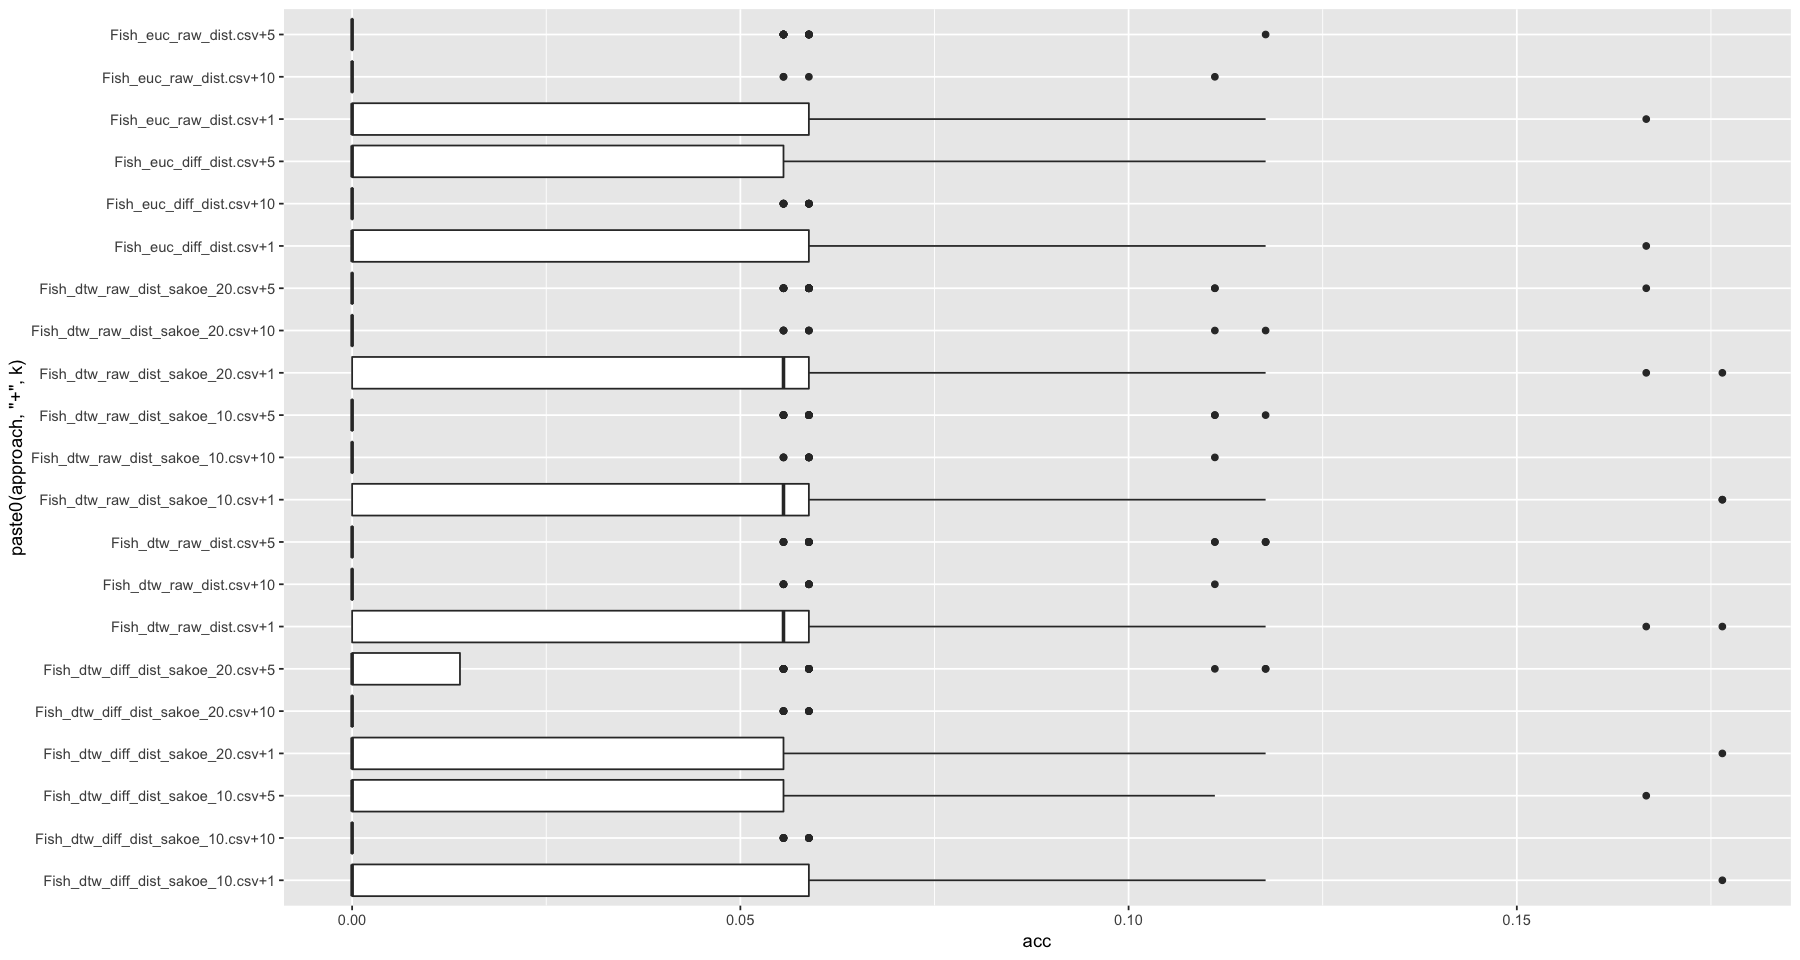

In [38]:
ggplot(overall_results2,aes(x=paste0(approach,'+',k), y=acc)) +
geom_boxplot()+
coord_flip()

In [39]:
dataset='Plane'
train_data_path=sprintf('%s/%s/%s_TRAIN.txt',current_folder,dataset,dataset)
test_data_path=sprintf('%s/%s/%s_TEST.txt',current_folder,dataset,dataset)
dist_path=sprintf('%s/%s/distances/%s',current_folder,dataset,dataset)

traindata=as.matrix(fread(train_data_path))
testdata=as.matrix(fread(test_data_path))

trainclass=traindata[,1] 
testclass=testdata[,1] 

traindata=traindata[,2:ncol(traindata)]
testdata=testdata[,2:ncol(testdata)]

tlength=ncol(traindata)
n_series_train=nrow(traindata)
n_series_test=nrow(testdata)


head(traindata)

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145
2.483940,2.2762865,2.0675157,1.9218926,1.7187752,1.50842850,1.3006752,1.0902862,0.8827328,0.6723009,...,0.7133945,0.9158603,1.1204496,1.3263464,1.5322099,1.7399188,1.9457323,2.1539857,2.3612278,2.4839393
2.603320,2.3406991,2.0822848,1.8256242,1.5677057,1.31220300,1.0571948,0.8017157,0.5466832,0.2918485,...,0.4272742,0.6760656,0.9212985,1.1717223,1.4188965,1.6636066,1.9158275,2.1624669,2.4052760,2.6052935
2.757321,2.5766667,2.3633233,2.1515785,1.9402183,1.72942750,1.5194285,1.3095473,1.1002525,0.8914930,...,0.9542680,1.1573429,1.3633172,1.5663255,1.7698597,1.9738637,2.1782898,2.3808412,2.5849446,2.7591348
0.916063,0.7201453,0.5224446,0.3258262,0.1343814,-0.05401188,-0.2355249,-0.4096045,-0.5744532,-0.7823530,...,1.1333979,0.9843523,0.7606417,0.5415025,0.5173423,0.5828356,0.6586408,0.7579009,0.8534012,0.9162167
2.656142,2.3881447,2.1185954,1.8496769,1.5765789,1.31016860,1.1096989,0.9309980,0.7506683,0.5393333,...,0.6366630,0.7924025,0.9860716,1.1789434,1.3926792,1.6603249,1.9292371,2.1991619,2.4699927,2.6555235
2.716798,2.5208585,2.3196204,2.1164411,1.9136371,1.71124980,1.5093279,1.3046473,1.1036170,0.8995841,...,0.9362289,1.1431900,1.3506284,1.5586054,1.7671641,1.9762411,2.1858814,2.3967625,2.6088970,2.7148302


In [40]:
# get difference series

dt_ts_train=data.table(traindata)
dt_ts_train[,id:=1:.N]
long_train=melt(dt_ts_train,id.vars=c('id'))
long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_train=long_train[order(id,time)]
long_train[,diff_series:=value-shift(value,1),by=list(id)]
head(long_train)

dt_ts_test=data.table(testdata)
dt_ts_test[,id:=1:.N]
long_test=melt(dt_ts_test,id.vars=c('id'))
long_test[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_test=long_test[order(id,time)]
long_test[,diff_series:=value-shift(value,1),by=list(id)]
head(long_test)

diff_train=dcast(long_train[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_train)
diff_train=as.matrix(diff_train)

diff_test=dcast(long_test[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_test)
diff_test=as.matrix(diff_test)

id,variable,value,time,diff_series
1,V2,2.483940,1,NA
1,V3,2.276286,2,-0.2076532
1,V4,2.067516,3,-0.2087708
1,V5,1.921893,4,-0.1456231
1,V6,1.718775,5,-0.2031174
1,V7,1.508428,6,-0.2103467


id,variable,value,time,diff_series
1,V2,2.684302,1,NA
1,V3,2.453768,2,-0.2305346
1,V4,2.230384,3,-0.2233833
1,V5,2.011169,4,-0.2192152
1,V6,1.794118,5,-0.2170510
1,V7,1.577387,6,-0.2167312


id,2,3,4,5,6,7,8,9,10,...,135,136,137,138,139,140,141,142,143,144
1,-0.2076532,-0.2087708,-0.1456231,-0.2031174,-0.2103467,-0.2077533,-0.2103890,-0.2075534,-0.2104320,...,0.2078874,0.2024657,0.2045893,0.2058968,0.20586350,0.20770890,0.20581350,0.2082534,0.2072421,0.12271150
2,-0.2626211,-0.2584143,-0.2566606,-0.2579185,-0.2555027,-0.2550082,-0.2554791,-0.2550325,-0.2548347,...,0.2531303,0.2487915,0.2452329,0.2504238,0.24717420,0.24471010,0.25222090,0.2466394,0.2428091,0.20001750
3,-0.1806546,-0.2133434,-0.2117448,-0.2113602,-0.2107908,-0.2099990,-0.2098812,-0.2092948,-0.2087595,...,0.2041258,0.2030749,0.2059743,0.2030083,0.20353420,0.20400400,0.20442610,0.2025514,0.2041034,0.17419020
4,-0.1959177,-0.1977007,-0.1966184,-0.1914449,-0.1883932,-0.1815130,-0.1740796,-0.1648487,-0.2078997,...,0.1456595,-0.1490456,-0.2237106,-0.2191392,-0.02416021,0.06549338,0.07580515,0.0992601,0.0955003,0.06281551
5,-0.2679977,-0.2695493,-0.2689185,-0.2730980,-0.2664103,-0.2004697,-0.1787009,-0.1803296,-0.2113351,...,0.2283102,0.1557395,0.1936691,0.1928718,0.21373580,0.26764570,0.26891220,0.2699248,0.2708308,0.18553080
6,-0.1959393,-0.2012381,-0.2031793,-0.2028040,-0.2023873,-0.2019219,-0.2046806,-0.2010303,-0.2040329,...,0.2064266,0.2069611,0.2074384,0.2079770,0.20855870,0.20907700,0.20964030,0.2108811,0.2121345,0.10593320


id,2,3,4,5,6,7,8,9,10,...,135,136,137,138,139,140,141,142,143,144
1,-0.2305346,-0.2233833,-0.2192152,-0.2170510,-0.2167312,-0.2177070,-0.2151941,-0.2173496,-0.2142329,...,0.2049979,0.1986944,0.2058684,0.1998755,0.2004871,0.20103590,0.19596160,0.20215730,0.1932753,0.0793574
2,-0.2369987,-0.2216548,-0.1997130,-0.2277058,-0.2195440,-0.2160221,-0.2085651,-0.2161005,-0.2159397,...,0.1998324,0.2022380,0.1964116,0.1968589,0.1876080,0.19745000,0.19803040,0.18882910,0.1439807,0.0438690
3,-0.2017020,-0.2008705,-0.2004586,-0.2006500,-0.2007657,-0.1972629,-0.2014662,-0.2014283,-0.2028176,...,0.2005127,0.1984452,0.1933322,0.2030858,0.2010217,0.19862580,0.19844430,0.19932880,0.1982186,0.1573688
4,-0.2098120,-0.1878521,-0.1786720,-0.1745628,-0.1736978,-0.1730229,-0.1599707,-0.1571389,-0.1716884,...,0.1685524,-0.0456864,-0.2291181,-0.2289495,-0.1438667,0.05920727,0.07685969,0.09366587,0.1091813,0.0649883
5,-0.2542476,-0.2514923,-0.2513270,-0.2504930,-0.2502958,-0.2334105,-0.1580987,-0.1722962,-0.1537311,...,0.1582730,0.1738587,0.1991595,0.1820872,0.2425660,0.24624630,0.24657480,0.24522150,0.2442741,0.1513482
6,-0.2675950,-0.2642936,-0.2621836,-0.2612909,-0.2600080,-0.2579750,-0.2604409,-0.2592651,-0.2589394,...,0.2542284,0.2572007,0.2540178,0.2584439,0.2431273,0.23918050,0.25208210,0.24951630,0.2479390,0.2218756


In [41]:
# calculate distances and store them to save time
large_number=10000
dist_euc=as.matrix(dist(traindata))
diag(dist_euc)=large_number
fwrite(dist_euc,sprintf('%s_euc_raw_dist.csv',dist_path),col.names=F)

dist_diff_euc=as.matrix(dist(diff_train))
diag(dist_diff_euc)=large_number
fwrite(dist_diff_euc,sprintf('%s_euc_diff_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata,window.type='sakoechiba',window.size=10))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_10.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata,window.type='sakoechiba',window.size=20))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_20.csv',dist_path),col.names=F)   
                   
diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=10))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_10.csv',dist_path),col.names=F)

diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=20))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_20.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [42]:
# cv indices start here

set.seed(13429)
nof_rep=10
n_fold=10
cv_indices=generateCVRuns(trainclass, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

str(cv_indices)

dist_folder=sprintf('%s/%s/distances/',current_folder,dataset)
dist_files=list.files(dist_folder, full.names=T)

dist_folder=sprintf('%s/%s/distances/',current_folder,dataset)
dist_files=list.files(dist_folder, full.names=T)

list.files(dist_folder)


List of 10
 $ Run  1 :List of 10
  ..$ Fold  1 : int [1:11] 1 38 40 15 35 4 67 28 32 49 ...
  ..$ Fold  2 : int [1:11] 83 42 60 6 99 46 54 104 57 51 ...
  ..$ Fold  3 : int [1:11] 48 56 26 22 100 85 89 5 50 20 ...
  ..$ Fold  4 : int [1:11] 33 27 80 21 29 86 41 9 82 24 ...
  ..$ Fold  5 : int [1:11] 95 39 58 3 11 77 78 79 69 74 ...
  ..$ Fold  6 : int [1:10] 8 18 19 16 65 93 61 87 14 98
  ..$ Fold  7 : int [1:10] 72 88 90 75 13 45 97 53 23 96
  ..$ Fold  8 : int [1:10] 84 105 2 73 81 43 34 102 12 71
  ..$ Fold  9 : int [1:10] 101 68 44 94 7 63 37 30 66 59
  ..$ Fold  10: int [1:10] 17 47 103 10 25 91 62 92 36 64
 $ Run  2 :List of 10
  ..$ Fold  1 : int [1:11] 27 1 80 44 13 91 93 34 14 51 ...
  ..$ Fold  2 : int [1:11] 101 38 15 73 100 43 67 61 36 98 ...
  ..$ Fold  3 : int [1:11] 56 48 47 94 16 86 28 9 49 23 ...
  ..$ Fold  4 : int [1:11] 39 95 88 10 22 63 62 89 69 50 ...
  ..$ Fold  5 : int [1:11] 8 17 105 99 65 46 37 79 57 66 ...
  ..$ Fold  6 : int [1:10] 33 2 58 6 21 45 78 87 30 1

[1] "Plane_dtw_diff_dist_sakoe_10.csv" "Plane_dtw_diff_dist_sakoe_20.csv"
[3] "Plane_dtw_raw_dist.csv"           "Plane_dtw_raw_dist_sakoe_10.csv" 
[5] "Plane_dtw_raw_dist_sakoe_20.csv"  "Plane_euc_diff_dist.csv"         
[7] "Plane_euc_raw_dist.csv"

In [43]:
k_levels=c(1,5,10)
approach_file=list.files(dist_folder)
result=vector('list',length(dist_files)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(dist_files)){ #
    print(dist_files[m])
    dist_mat=as.matrix(fread(dist_files[m],header=FALSE))
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass,test_indices,k=current_k)
                accuracy=sum(trainclass[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=approach_file[m],repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}


[1] "/Users/batuhantuncel/Plane/distances//Plane_dtw_diff_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/Plane/distances//Plane_dtw_diff_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/Plane/distances//Plane_dtw_raw_dist.csv"
[1] "/Users/batuhantuncel/Plane/distances//Plane_dtw_raw_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/Plane/distances//Plane_dtw_raw_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/Plane/distances//Plane_euc_diff_dist.csv"
[1] "/Users/batuhantuncel/Plane/distances//Plane_euc_raw_dist.csv"


In [44]:
overall_results_new_3=rbindlist(result)
summarized_results_new_3=overall_results_new_3[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]

summarized_results_new_3[order(-avg_acc)]


approach,k,avg_acc,sdev_acc,result_count
Plane_dtw_raw_dist.csv,10,0.2736364,0.2179770,100
Plane_dtw_raw_dist_sakoe_20.csv,10,0.2736364,0.2179770,100
Plane_euc_raw_dist.csv,10,0.2724545,0.1992492,100
Plane_dtw_raw_dist_sakoe_10.csv,10,0.2688182,0.2093852,100
Plane_dtw_diff_dist_sakoe_20.csv,10,0.2363636,0.1258082,100
Plane_dtw_diff_dist_sakoe_10.csv,10,0.2264545,0.1217488,100
Plane_dtw_diff_dist_sakoe_20.csv,5,0.2211818,0.1264109,100
Plane_euc_raw_dist.csv,5,0.2165455,0.1562958,100
Plane_euc_diff_dist.csv,10,0.2132727,0.1157258,100
Plane_dtw_raw_dist.csv,1,0.2121818,0.1418764,100


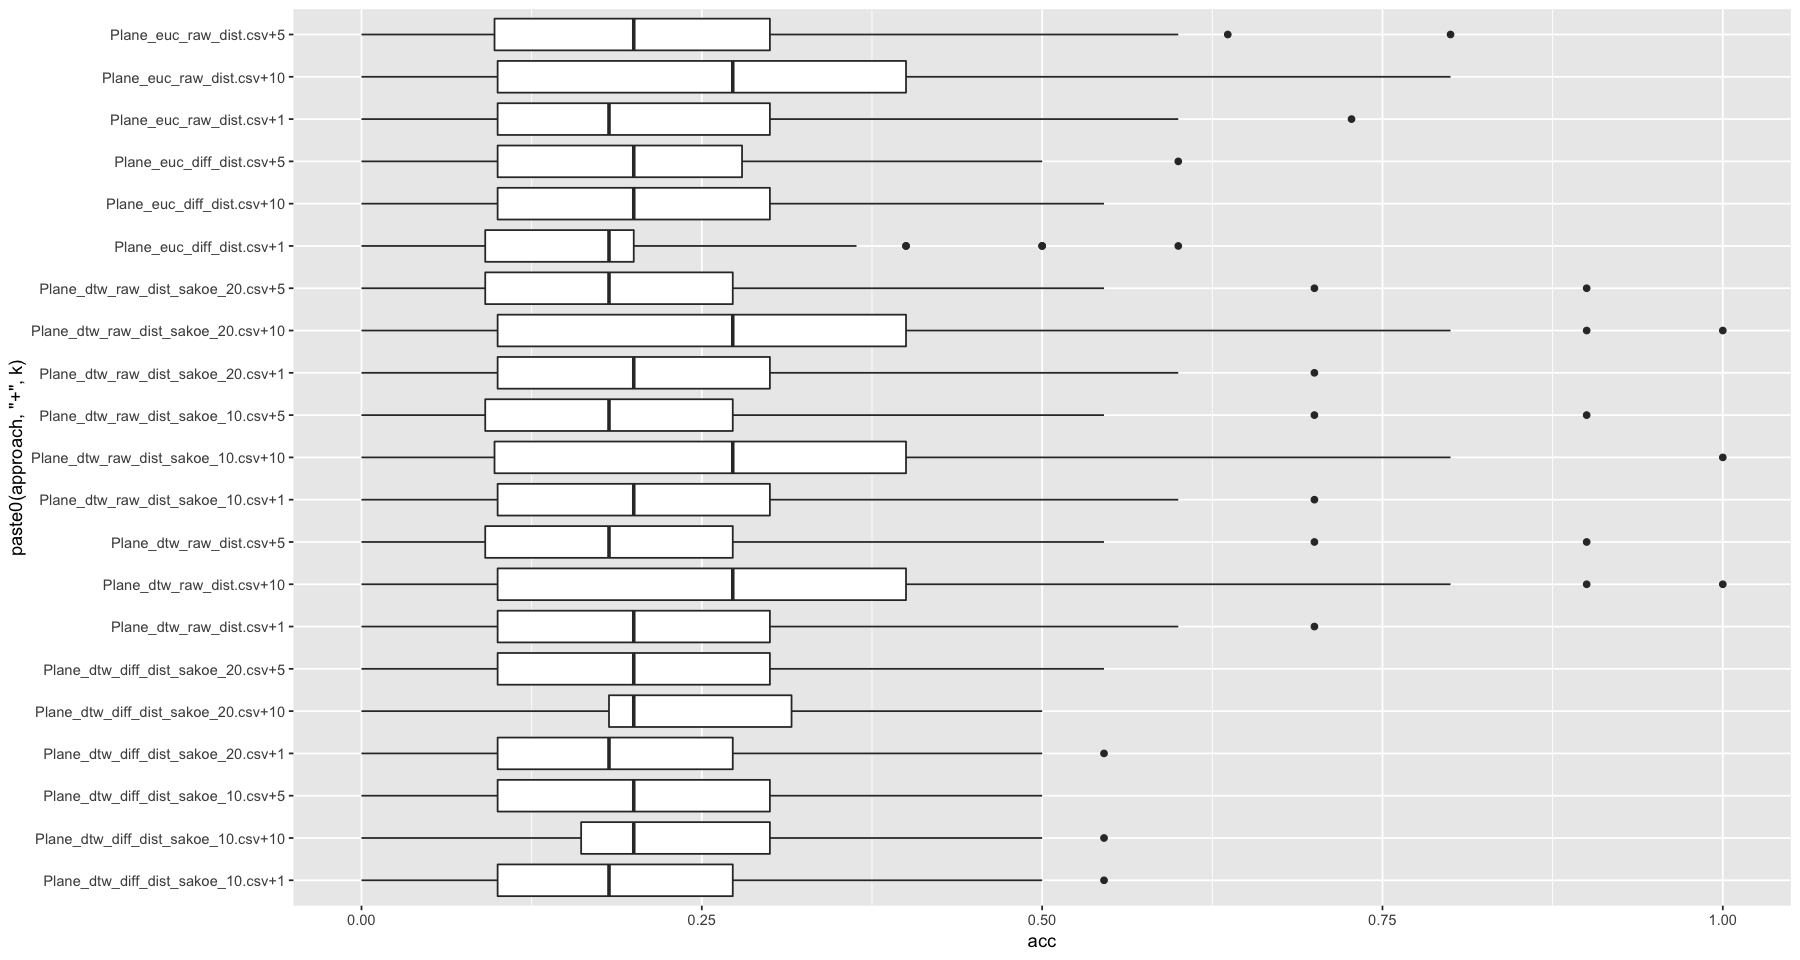

In [45]:
ggplot(overall_results_new_3,aes(x=paste0(approach,'+',k), y=acc)) +
geom_boxplot()+
coord_flip()

In [49]:
dataset='Trace'
train_data_path=sprintf('%s/%s/%s_TRAIN.txt',current_folder,dataset,dataset)
test_data_path=sprintf('%s/%s/%s_TEST.txt',current_folder,dataset,dataset)
dist_path=sprintf('%s/%s/distances/%s',current_folder,dataset,dataset)

traindata=as.matrix(fread(train_data_path))
testdata=as.matrix(fread(test_data_path))

trainclass=traindata[,1] 
testclass=testdata[,1] 

traindata=traindata[,2:ncol(traindata)]
testdata=testdata[,2:ncol(testdata)]

tlength=ncol(traindata)
n_series_train=nrow(traindata)
n_series_test=nrow(testdata)

head(traindata)

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276
0.5440704,0.6578630,0.6112391,0.5454131,0.5321561,0.5930125,0.5952802,0.5382770,0.5634290,0.5959565,...,0.5882259,0.5778859,0.5980693,0.5836949,0.6028774,0.5542635,0.5141473,0.6037730,0.5963312,0.5832243
0.7664298,0.6246319,0.7422470,0.6682216,0.7661175,0.7306850,0.6551092,0.7293299,0.7236512,0.7028178,...,0.6861941,0.6849958,0.6540068,0.6899813,0.6418135,0.6727988,0.6167308,0.7221820,0.6678562,0.7244464
-2.0450118,-2.0916771,-2.0776367,-2.0335167,-1.9901730,-2.0577092,-2.0128429,-2.0509702,-2.0553157,-2.0760096,...,0.5554665,0.5244291,0.4854120,0.5505320,0.5975501,0.6064284,0.5229343,0.5242872,0.5474246,0.5705620
-1.7050221,-1.7391240,-1.7256591,-1.8017184,-1.7425432,-1.7603664,-1.6915715,-1.6875198,-1.7615121,-1.7748398,...,0.6492796,0.6406937,0.6259908,0.6162145,0.6168793,0.6565181,0.5959919,0.6016442,0.6561640,0.5822592
0.5413721,0.5719079,0.5621467,0.5209509,0.5274937,0.6040431,0.5405210,0.5803829,0.5005821,0.5978125,...,0.5860001,0.6264716,0.6096163,0.5542846,0.5394653,0.5335154,0.5577524,0.5078255,0.5137685,0.5281315
-1.2781808,-1.2707170,-1.2754118,-1.2440114,-1.2965360,-1.2243645,-1.2484483,-1.2160164,-1.2532291,-1.2904419,...,0.8778366,0.8723218,0.8668069,0.9067330,0.8248119,0.8579634,0.8263804,0.8625157,0.8396326,0.8721966


In [50]:
dt_ts_train=data.table(traindata)
dt_ts_train[,id:=1:.N]
long_train=melt(dt_ts_train,id.vars=c('id'))
long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_train=long_train[order(id,time)]
long_train[,diff_series:=value-shift(value,1),by=list(id)]
head(long_train)

dt_ts_test=data.table(testdata)
dt_ts_test[,id:=1:.N]
long_test=melt(dt_ts_test,id.vars=c('id'))
long_test[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_test=long_test[order(id,time)]
long_test[,diff_series:=value-shift(value,1),by=list(id)]
head(long_test)

diff_train=dcast(long_train[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_train)
diff_train=as.matrix(diff_train)

diff_test=dcast(long_test[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_test)
diff_test=as.matrix(diff_test)

id,variable,value,time,diff_series
1,V2,0.5440704,1,NA
1,V3,0.6578630,2,0.11379262
1,V4,0.6112391,3,-0.04662396
1,V5,0.5454131,4,-0.06582596
1,V6,0.5321561,5,-0.01325704
1,V7,0.5930125,6,0.06085644


id,variable,value,time,diff_series
1,V2,-1.296736,1,NA
1,V3,-1.333738,2,-0.0370024
1,V4,-1.349496,3,-0.0157577
1,V5,-1.318587,4,0.0309092
1,V6,-1.307479,5,0.0111077
1,V7,-1.255202,6,0.0522766


id,2,3,4,5,6,7,8,9,10,...,266,267,268,269,270,271,272,273,274,275
1,0.1137926,-0.04662396,-0.06582596,-0.01325704,0.06085644,0.00226769,-0.05700323,0.02515203,0.03252746,...,0.01000183,-0.01033999,0.02018346,-0.01437446,0.01918254,-0.04861394,-0.04011620,0.08962576,-0.00744180,-0.01310697
2,-0.1417979,0.11761513,-0.07402537,0.09789587,-0.03543251,-0.07557576,0.07422067,-0.00567872,-0.02083342,...,0.01855474,-0.00119834,-0.03098902,0.03597456,-0.04816788,0.03098532,-0.05606796,0.10545121,-0.05432582,0.05659019
3,-0.0466653,0.01404040,0.04412000,0.04334370,-0.06753620,0.04486630,-0.03812730,-0.00434550,-0.02069390,...,0.03046504,-0.03103735,-0.03901713,0.06512002,0.04701809,0.00887826,-0.08349410,0.00135294,0.02313736,0.02313740
4,-0.0341019,0.01346490,-0.07605930,0.05917520,-0.01782320,0.06879490,0.00405170,-0.07399230,-0.01332770,...,0.03503722,-0.00858587,-0.01470294,-0.00977622,0.00066473,0.03963881,-0.06052622,0.00565230,0.05451980,-0.07390480
5,0.0305358,-0.00976116,-0.04119579,0.00654284,0.07654931,-0.06352201,0.03986187,-0.07980082,0.09723035,...,0.03873991,0.04047150,-0.01685531,-0.05533169,-0.01481928,-0.00594992,0.02423706,-0.04992697,0.00594302,0.01436302
6,0.0074638,-0.00469480,0.03140040,-0.05252460,0.07217150,-0.02408380,0.03243190,-0.03721270,-0.03721280,...,0.03812529,-0.00551482,-0.00551484,0.03992606,-0.08192113,0.03315150,-0.03158297,0.03613534,-0.02288314,0.03256397


id,2,3,4,5,6,7,8,9,10,...,266,267,268,269,270,271,272,273,274,275
1,-0.03700240,-0.01575770,0.03090920,0.01110770,0.05227660,-0.01794220,0.01885800,-0.04470280,0.00821650,...,-0.02006571,0.03371373,-0.06868827,0.01932961,0.01932961,-0.01106777,0.01200244,-0.00293308,-0.00293306,-0.02200493
2,-0.01909758,-0.00306946,0.02111039,0.05704069,-0.03822352,0.01662865,-0.02001951,0.03362953,0.00993676,...,-0.00757656,0.00898691,0.04328881,-0.10000539,0.04791007,0.05758573,-0.09536522,0.04036729,0.01485730,0.00467016
3,0.01257790,0.06310100,-0.07513930,0.01411310,0.05556910,-0.02704830,-0.03668030,0.07487250,-0.08117880,...,0.05479386,-0.09344659,0.04129556,0.02085726,-0.01086312,0.02370691,-0.02907887,0.00080261,0.00080261,0.00012630
4,-0.01026728,0.02968278,0.06462652,-0.08839311,0.02665952,0.05058428,-0.00864903,-0.07382622,-0.02493885,...,0.02636692,-0.05104720,0.04109546,-0.01250281,-0.03191235,0.06303057,-0.06399846,0.03255299,0.02624641,-0.00633857
5,-0.05253743,0.03805531,0.00618553,0.01171337,0.00317660,-0.02393467,0.00916260,0.06372965,-0.06359010,...,-0.03069168,-0.03069168,0.03362695,-0.00303579,0.01835682,0.00319283,0.00618670,-0.01187522,-0.01411390,0.02780776
6,0.01606500,-0.04115130,0.03049170,0.04296540,-0.04270640,-0.02352280,-0.01898810,0.04762480,-0.03040910,...,0.00252913,0.03175895,-0.00431925,-0.01797995,0.01375765,-0.01319198,0.01940184,-0.01123532,0.05960008,-0.08043453


In [51]:
# calculate distances and store them to save time
large_number=10000
dist_euc=as.matrix(dist(traindata))
diag(dist_euc)=large_number
fwrite(dist_euc,sprintf('%s_euc_raw_dist.csv',dist_path),col.names=F)

dist_diff_euc=as.matrix(dist(diff_train))
diag(dist_diff_euc)=large_number
fwrite(dist_diff_euc,sprintf('%s_euc_diff_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata,window.type='sakoechiba',window.size=10))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_10.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata,window.type='sakoechiba',window.size=20))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_20.csv',dist_path),col.names=F)   
                   
diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=10))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_10.csv',dist_path),col.names=F)

diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=20))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_20.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [52]:
# cv indices start here

set.seed(13429)
nof_rep=10
n_fold=10
cv_indices=generateCVRuns(trainclass, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

str(cv_indices)

dist_folder=sprintf('%s/%s/distances/',current_folder,dataset)
dist_files=list.files(dist_folder, full.names=T)

dist_folder=sprintf('%s/%s/distances/',current_folder,dataset)
dist_files=list.files(dist_folder, full.names=T)

list.files(dist_folder)

List of 10
 $ Run  1 :List of 10
  ..$ Fold  1 : int [1:10] 74 83 9 38 57 87 11 63 64 41
  ..$ Fold  2 : int [1:10] 96 8 99 73 24 28 93 21 44 75
  ..$ Fold  3 : int [1:10] 16 46 1 67 56 15 7 47 72 82
  ..$ Fold  4 : int [1:10] 94 81 31 89 2 20 34 6 52 14
  ..$ Fold  5 : int [1:10] 60 78 68 26 59 33 10 30 80 84
  ..$ Fold  6 : int [1:10] 77 32 5 62 97 55 27 92 95 65
  ..$ Fold  7 : int [1:10] 88 25 18 58 66 19 91 48 45 61
  ..$ Fold  8 : int [1:10] 39 90 53 100 51 13 98 3 43 42
  ..$ Fold  9 : int [1:10] 37 40 50 29 76 12 49 85 23 17
  ..$ Fold  10: int [1:10] 54 36 71 35 22 69 70 4 86 79
 $ Run  2 :List of 10
  ..$ Fold  1 : int [1:10] 37 77 78 2 62 7 49 15 64 85
  ..$ Fold  2 : int [1:10] 90 96 9 35 58 28 20 3 75 80
  ..$ Fold  3 : int [1:10] 25 54 60 57 89 30 47 76 61 42
  ..$ Fold  4 : int [1:10] 83 5 31 38 50 69 92 91 72 65
  ..$ Fold  5 : int [1:10] 40 32 1 59 71 11 6 98 52 43
  ..$ Fold  6 : int [1:10] 39 46 81 66 73 93 34 51 82 79
  ..$ Fold  7 : int [1:10] 74 36 67 29 56 22 10 

[1] "Trace_dtw_diff_dist_sakoe_10.csv" "Trace_dtw_diff_dist_sakoe_20.csv"
[3] "Trace_dtw_raw_dist.csv"           "Trace_dtw_raw_dist_sakoe_10.csv" 
[5] "Trace_dtw_raw_dist_sakoe_20.csv"  "Trace_euc_diff_dist.csv"         
[7] "Trace_euc_raw_dist.csv"

In [53]:
k_levels=c(1,5,10)
approach_file=list.files(dist_folder)
result=vector('list',length(dist_files)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(dist_files)){ #
    print(dist_files[m])
    dist_mat=as.matrix(fread(dist_files[m],header=FALSE))
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass,test_indices,k=current_k)
                accuracy=sum(trainclass[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=approach_file[m],repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

[1] "/Users/batuhantuncel/Trace/distances//Trace_dtw_diff_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/Trace/distances//Trace_dtw_diff_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/Trace/distances//Trace_dtw_raw_dist.csv"
[1] "/Users/batuhantuncel/Trace/distances//Trace_dtw_raw_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/Trace/distances//Trace_dtw_raw_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/Trace/distances//Trace_euc_diff_dist.csv"
[1] "/Users/batuhantuncel/Trace/distances//Trace_euc_raw_dist.csv"


In [54]:
overall_results_new_4=rbindlist(result)
summarized_results_new_4=overall_results_new_4[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]

summarized_results_new_4[order(-avg_acc)]

approach,k,avg_acc,sdev_acc,result_count
Trace_euc_diff_dist.csv,10,0.361,0.1427684,100
Trace_dtw_raw_dist_sakoe_20.csv,1,0.356,0.1603783,100
Trace_euc_raw_dist.csv,1,0.346,0.1604413,100
Trace_dtw_diff_dist_sakoe_10.csv,10,0.344,0.1233538,100
Trace_euc_diff_dist.csv,5,0.342,0.1288488,100
Trace_dtw_raw_dist_sakoe_20.csv,5,0.342,0.1832259,100
Trace_dtw_raw_dist.csv,10,0.339,0.2068987,100
Trace_dtw_raw_dist.csv,1,0.334,0.1683071,100
Trace_dtw_raw_dist_sakoe_20.csv,10,0.334,0.1939593,100
Trace_dtw_raw_dist_sakoe_10.csv,5,0.332,0.1757409,100


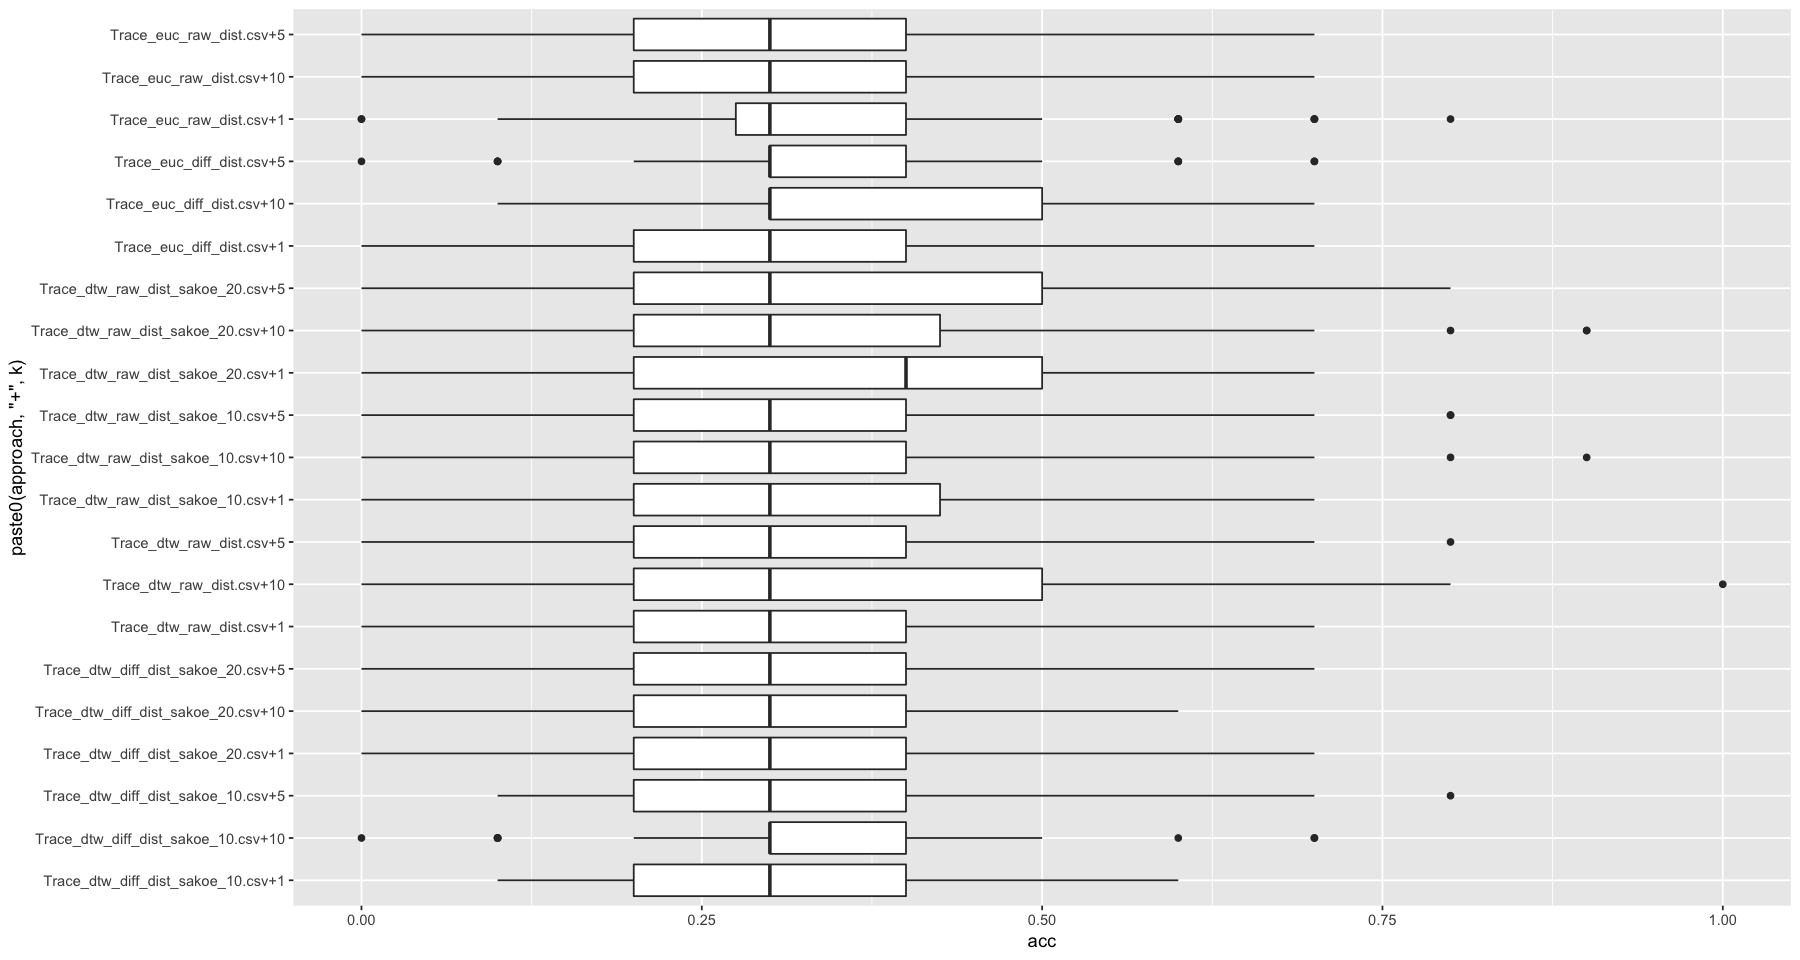

In [55]:
ggplot(overall_results_new_4,aes(x=paste0(approach,'+',k), y=acc)) +
geom_boxplot()+
coord_flip()

In [56]:
dataset='SyntheticControl'
train_data_path=sprintf('%s/%s/%s_TRAIN.txt',current_folder,dataset,dataset)
test_data_path=sprintf('%s/%s/%s_TEST.txt',current_folder,dataset,dataset)
dist_path=sprintf('%s/%s/distances/%s',current_folder,dataset,dataset)

traindata=as.matrix(fread(train_data_path))
testdata=as.matrix(fread(test_data_path))

trainclass=traindata[,1] 
testclass=testdata[,1] 

traindata=traindata[,2:ncol(traindata)]
testdata=testdata[,2:ncol(testdata)]

tlength=ncol(traindata)
n_series_train=nrow(traindata)
n_series_test=nrow(testdata)


head(traindata)


V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61
-0.3769356,1.22486430,0.3438744,0.3284540,-0.3376094,1.02651400,-1.3309960,-0.6578003,1.4460774,-0.8463966,...,0.37071200,-1.5681650,1.02186260,-1.4297483,1.356966,1.3727813,0.6635578,0.9183460,-1.31174170,-1.19714620
0.6444062,0.41326914,-0.8622785,-1.4973857,-0.4214578,-0.21421485,-1.2921314,0.9568977,-1.2161403,-0.5885358,...,1.31726790,-0.8025282,-1.12128700,0.9893190,-1.109687,0.2198564,0.6300336,1.3981403,0.08574208,0.02499741
-0.9786674,-0.40623244,0.8224286,-1.4082424,-1.6767337,-0.49063202,1.4045976,1.1685996,-1.7032538,0.9728103,...,-0.82878343,-0.7628843,1.38297230,-0.8691028,1.277252,-0.1989668,0.9668094,0.6661290,0.10699555,0.08271546
-0.2365366,-0.09817465,0.3670918,1.3668598,0.4982812,-0.30022317,1.7156337,0.9021076,-0.2181317,-1.4307205,...,0.06890446,-1.4996038,0.40674365,1.2891530,-1.119731,-0.9959846,1.6511352,-1.1870984,0.02546335,-0.84151833
1.4907351,1.32524300,1.6268292,-0.3170562,-1.0989904,-0.02221261,0.5969804,1.6673392,-0.2061527,-1.3766266,...,0.81506544,1.0299949,-1.49616070,-1.1674420,1.484208,-0.3730204,-0.8432813,-0.2097938,0.13772357,0.71654152
1.6433162,1.76401080,0.4377555,0.1993101,-1.5676161,-0.71911748,-1.0941885,1.0331764,-1.3771657,-0.9489048,...,0.28208201,-1.3686807,0.09789432,-0.4252310,0.575449,-0.9120210,1.3174235,-0.3972652,0.20926698,-0.04531146


In [57]:
# get difference series

dt_ts_train=data.table(traindata)
dt_ts_train[,id:=1:.N]
long_train=melt(dt_ts_train,id.vars=c('id'))
long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_train=long_train[order(id,time)]
long_train[,diff_series:=value-shift(value,1),by=list(id)]
head(long_train)

dt_ts_test=data.table(testdata)
dt_ts_test[,id:=1:.N]
long_test=melt(dt_ts_test,id.vars=c('id'))
long_test[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_test=long_test[order(id,time)]
long_test[,diff_series:=value-shift(value,1),by=list(id)]
head(long_test)

diff_train=dcast(long_train[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_train)
diff_train=as.matrix(diff_train)

diff_test=dcast(long_test[!is.na(diff_series)],id~time,value.var='diff_series')
head(diff_test)
diff_test=as.matrix(diff_test)

id,variable,value,time,diff_series
1,V2,-0.3769356,1,NA
1,V3,1.2248643,2,1.60179988
1,V4,0.3438744,3,-0.88098992
1,V5,0.3284540,4,-0.01542035
1,V6,-0.3376094,5,-0.66606348
1,V7,1.0265140,6,1.36412345


id,variable,value,time,diff_series
1,V2,-1.4139728,1,NA
1,V3,-1.1620647,2,0.2519081
1,V4,-0.6241739,3,0.5378908
1,V5,0.9396037,4,1.5637776
1,V6,-0.5275007,5,-1.4671044
1,V7,0.5747866,6,1.1022873


id,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
1,1.6017999,-0.8809899,-0.01542035,-0.6660635,1.3641234,-2.3575100,0.6731957,2.103878,-2.2924740,...,0.4753811,-1.93887700,2.5900276,-2.4516109,2.786715,0.0158150,-0.7092235,0.2547882,-2.2300877,0.11459550
2,-0.2311371,-1.2755476,-0.63510721,1.0759279,0.2072430,-1.0779165,2.2490292,-2.173038,0.6276045,...,1.9465111,-2.11979606,-0.3187588,2.1106060,-2.099006,1.3295429,0.4101772,0.7681067,-1.3123982,-0.06074467
3,0.5724349,1.2286610,-2.23067097,-0.2684913,1.1861017,1.8952296,-0.2359980,-2.871853,2.6760641,...,-1.9917969,0.06589915,2.1458566,-2.2520751,2.146354,-1.4762184,1.1657761,-0.3006804,-0.5591334,-0.02428009
4,0.1383620,0.4652664,0.99976800,-0.8685786,-0.7985044,2.0158569,-0.8135261,-1.120239,-1.2125888,...,1.5637446,-1.56850826,1.9063475,0.8824093,-2.408884,0.1237463,2.6471198,-2.8382336,1.2125617,-0.86698168
5,-0.1654921,0.3015862,-1.94388537,-0.7819342,1.0767778,0.6191931,1.0703588,-1.873492,-1.1704739,...,0.1942159,0.21492946,-2.5261556,0.3287187,2.651650,-1.8572286,-0.4702609,0.6334875,0.3475173,0.57881795
6,0.1206946,-1.3262553,-0.23844542,-1.7669262,0.8484986,-0.3750710,2.1273649,-2.410342,0.4282609,...,1.2455902,-1.65076271,1.4665750,-0.5231254,1.000680,-1.4874700,2.2294445,-1.7146887,0.6065322,-0.25457844


id,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
1,0.2519081,0.5378908,1.56377757,-1.4671044,1.1022873,-0.03161096,1.2053123,-2.2544101,1.1005658,...,0.9358623,-0.4562663,-1.2996703,0.5316873,1.5503615,-2.1465767,0.6060102,1.7162819,-0.6375321,-1.6056287
2,1.3530794,1.3936530,-2.79533530,0.6738633,-0.7687058,0.81483156,0.3686644,0.5774547,-1.1773174,...,0.9889137,-1.6807717,-0.1219201,0.9341322,0.8646873,-0.5883598,-0.4460248,-1.7336739,0.7038735,-0.5862527
3,1.2182800,-0.4878577,1.82042783,-0.1936196,-1.7431733,0.83709493,-1.4134629,1.2727391,-1.0227560,...,-1.2033577,2.5274861,-2.5935419,-0.4403623,0.6187470,-0.6058997,2.3470833,-2.6597113,2.5744414,0.6605009
4,0.9540294,0.3542234,-0.19391070,-1.1937194,1.3024454,0.17798990,-2.8308413,0.8468897,0.9398083,...,1.3713127,-1.2207734,-1.9497020,1.5509457,1.7618536,0.0232863,-2.7286593,1.9256792,-0.5330632,0.9123293
5,0.6026211,0.4349038,0.62527589,-1.0395118,0.9116854,-1.67719871,1.4687648,-0.3108962,0.6643153,...,0.4991525,-2.6261689,1.2998348,0.7110181,-0.0844263,-2.3039969,2.2659122,-0.9263155,1.6031193,-2.4721786
6,-0.7307622,1.6558279,-0.02207994,0.4482228,0.6208377,-1.96075470,0.5526973,-0.7465536,2.6962124,...,0.7483144,-1.1943571,1.0405242,0.9967836,-3.1356033,1.8003258,-0.4956248,1.8379734,-3.0023689,2.5485283


In [58]:
# calculate distances and store them to save time
large_number=10000
dist_euc=as.matrix(dist(traindata))
diag(dist_euc)=large_number
fwrite(dist_euc,sprintf('%s_euc_raw_dist.csv',dist_path),col.names=F)

dist_diff_euc=as.matrix(dist(diff_train))
diag(dist_diff_euc)=large_number
fwrite(dist_diff_euc,sprintf('%s_euc_diff_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata,window.type='sakoechiba',window.size=10))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_10.csv',dist_path),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata,window.type='sakoechiba',window.size=20))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist_sakoe_20.csv',dist_path),col.names=F)   
                   
diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=10))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_10.csv',dist_path),col.names=F)

diff_dist_dtw=as.matrix(dtwDist(diff_train,window.type='sakoechiba',window.size=20))
diag(diff_dist_dtw)=large_number
fwrite(diff_dist_dtw,sprintf('%s_dtw_diff_dist_sakoe_20.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [59]:
# cv indices start here

set.seed(13429)
nof_rep=10
n_fold=10
cv_indices=generateCVRuns(trainclass, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

str(cv_indices)

dist_folder=sprintf('%s/%s/distances/',current_folder,dataset)
dist_files=list.files(dist_folder, full.names=T)

dist_folder=sprintf('%s/%s/distances/',current_folder,dataset)
dist_files=list.files(dist_folder, full.names=T)

list.files(dist_folder)

List of 10
 $ Run  1 :List of 10
  ..$ Fold  1 : int [1:30] 49 19 34 20 39 98 53 75 93 94 ...
  ..$ Fold  2 : int [1:30] 25 29 23 27 10 72 74 97 85 61 ...
  ..$ Fold  3 : int [1:30] 5 3 17 41 50 79 65 89 69 100 ...
  ..$ Fold  4 : int [1:30] 37 11 24 48 33 91 62 64 82 83 ...
  ..$ Fold  5 : int [1:30] 31 44 2 14 4 57 76 84 73 56 ...
  ..$ Fold  6 : int [1:30] 15 28 9 6 46 88 99 70 81 95 ...
  ..$ Fold  7 : int [1:30] 43 13 8 47 21 71 68 60 52 86 ...
  ..$ Fold  8 : int [1:30] 22 12 35 45 16 66 51 96 55 90 ...
  ..$ Fold  9 : int [1:30] 42 36 7 18 40 87 78 54 63 59 ...
  ..$ Fold  10: int [1:30] 26 38 32 1 30 58 92 67 80 77 ...
 $ Run  2 :List of 10
  ..$ Fold  1 : int [1:30] 12 22 47 20 43 80 87 56 60 66 ...
  ..$ Fold  2 : int [1:30] 5 28 50 25 36 51 68 78 53 52 ...
  ..$ Fold  3 : int [1:30] 9 31 7 46 41 96 92 67 58 100 ...
  ..$ Fold  4 : int [1:30] 24 30 3 6 29 81 74 86 64 77 ...
  ..$ Fold  5 : int [1:30] 10 40 19 33 48 70 89 71 84 83 ...
  ..$ Fold  6 : int [1:30] 35 42 2 8 14 79

[1] "SyntheticControl_dtw_diff_dist_sakoe_10.csv"
[2] "SyntheticControl_dtw_diff_dist_sakoe_20.csv"
[3] "SyntheticControl_dtw_raw_dist.csv"          
[4] "SyntheticControl_dtw_raw_dist_sakoe_10.csv" 
[5] "SyntheticControl_dtw_raw_dist_sakoe_20.csv" 
[6] "SyntheticControl_euc_diff_dist.csv"         
[7] "SyntheticControl_euc_raw_dist.csv"

In [60]:
k_levels=c(1,5,10)
approach_file=list.files(dist_folder)
result=vector('list',length(dist_files)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(dist_files)){ #
    print(dist_files[m])
    dist_mat=as.matrix(fread(dist_files[m],header=FALSE))
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass,test_indices,k=current_k)
                accuracy=sum(trainclass[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=approach_file[m],repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

[1] "/Users/batuhantuncel/SyntheticControl/distances//SyntheticControl_dtw_diff_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/SyntheticControl/distances//SyntheticControl_dtw_diff_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/SyntheticControl/distances//SyntheticControl_dtw_raw_dist.csv"
[1] "/Users/batuhantuncel/SyntheticControl/distances//SyntheticControl_dtw_raw_dist_sakoe_10.csv"
[1] "/Users/batuhantuncel/SyntheticControl/distances//SyntheticControl_dtw_raw_dist_sakoe_20.csv"
[1] "/Users/batuhantuncel/SyntheticControl/distances//SyntheticControl_euc_diff_dist.csv"
[1] "/Users/batuhantuncel/SyntheticControl/distances//SyntheticControl_euc_raw_dist.csv"


In [61]:
overall_results_new_5=rbindlist(result)
summarized_results_new_5=overall_results_new_5[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]

summarized_results_new_5[order(-avg_acc)]


approach,k,avg_acc,sdev_acc,result_count
SyntheticControl_dtw_raw_dist.csv,10,0.7770000,0.05816016,100
SyntheticControl_dtw_raw_dist_sakoe_20.csv,10,0.7760000,0.05823440,100
SyntheticControl_dtw_raw_dist_sakoe_10.csv,10,0.7756667,0.06119920,100
SyntheticControl_dtw_raw_dist.csv,5,0.7660000,0.06598643,100
SyntheticControl_dtw_raw_dist_sakoe_20.csv,5,0.7633333,0.06791756,100
SyntheticControl_dtw_raw_dist_sakoe_10.csv,5,0.7613333,0.06678777,100
SyntheticControl_dtw_diff_dist_sakoe_10.csv,10,0.7270000,0.06958188,100
SyntheticControl_euc_diff_dist.csv,10,0.7266667,0.07415820,100
SyntheticControl_dtw_diff_dist_sakoe_20.csv,10,0.7243333,0.06992942,100
SyntheticControl_dtw_diff_dist_sakoe_10.csv,5,0.7240000,0.07843589,100


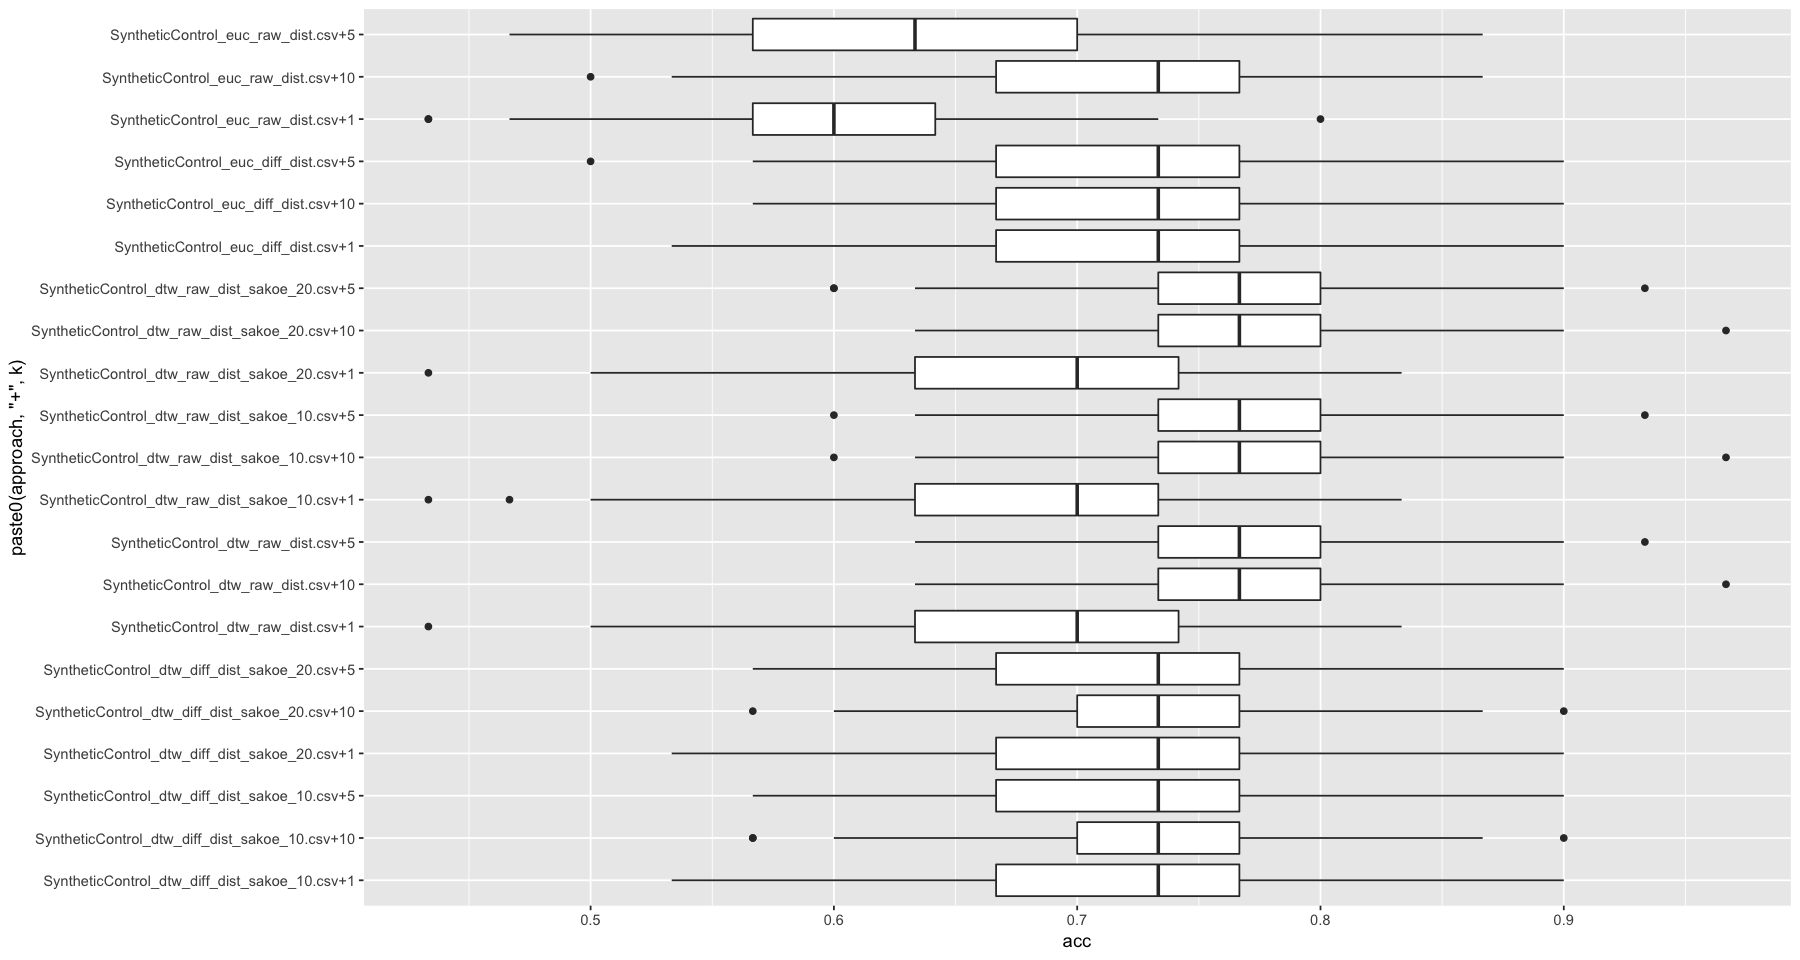

In [62]:
ggplot(overall_results_new_5,aes(x=paste0(approach,'+',k), y=acc)) +
geom_boxplot()+
coord_flip()